In [27]:
import swarms
from numpy import linspace, logspace, pi, array
import matplotlib.pyplot as plt

In [28]:
RHO=1500
M0 = 10 * 7.34767309e22; Dt = 100.; Dmax = 250000.; L_s = 10 * 3.828e26;
M_s = 1.86 * 1.989e30; M_pl = 1 * 1.89587112e27; a_pl = 50 * 1.496e11
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = 10 * 3.086e16
argv = [M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr, d_pl]

In [45]:
times = [1e7, 1e8, 1e9, 1e10] 
lamb = 1.65e-6
a_plv = linspace(2 * 1.496e11, 200 * 1.496e11, 500)
type_star = "A"

In [46]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [47]:
time_slices = []
a_opt_list = []
for j in range(len(times)):
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1./1.2)
    s.updateSwarm(times[j])
    T_star = s.stellarTemp()
    B_nu = s.computeBmu(lamb, T_star)
    F_star = Fstar(L_s, B_nu, T_star, d_pl)/1e-26
    print("Fstar")
    print(F_star)

    waverange = logspace(-7, -3, 200)
    B_nu_list = s.computeBmu(waverange, T_star)
    F_star_list = Fstar(L_s, B_nu_list, T_star, d_pl)/1e-26

    fth_list = []
    fs_list = []
    if (a_plv is not None):
        for i in range(len(a_plv)):
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                    a_plv[i], R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(times[j])

            F_th = s2.computeFth(array([lamb]), swarm=True)
            F_s = s2.computeFs(array([lamb]), 0.32, 0.08, swarm=True)

            fth_list.append(F_th[0]/1e-26)
            fs_list.append(F_s[0]/1e-26)

    f_vrel = 4/pi
    Qd = s.computeQd(s.Dc)
    part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
    part2 = (M_pl/5.972e24)**0.06 * Qd**0.15 * eta
    part3 = times[j] * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

    a_opt = 50 * part1 / part2 * part3**0.24 
    a_opt_list.append(a_opt)
    
    contrast_ratio_apl_th = array(fth_list) / F_star
    contrast_ratio_apl_s = array(fs_list) / F_star
    time_slices.append(contrast_ratio_apl_s)
    
    Fth_swarm = s.computeFth(waverange, swarm=True)/1e-26
    Fs_swarm = s.computeFs(waverange, 0.32, 0.08, swarm=True)/1e-26

    contrast_ratio_th = Fth_swarm / F_star_list
    contrast_ratio_s = Fs_swarm / F_star_list

Fstar
35.849665322236966
Fstar
35.849665322236966
Fstar
35.849665322236966
Fstar
35.849665322236966


C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)


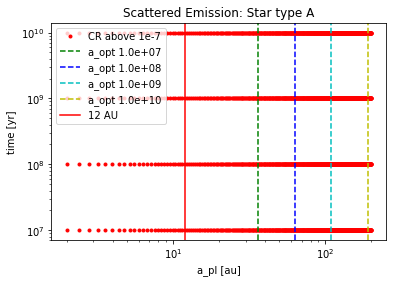

In [50]:
plt.figure(4)
label_flag1 = True
label_flag2 = True
for i in range(len(time_slices)):
    for j in range(len(time_slices[i])):
        if time_slices[i][j] >= 1e-7:
            if label_flag1:
                l = plt.plot(a_plv[j]/1.496e11, times[i], 'bo', label="CR below 1e-7")
                label_flag1 = False
                plt.setp(l, markersize=3)
            else:
                l = plt.plot(a_plv[j]/1.496e11, times[i], 'bo')
                plt.setp(l, markersize=3)
        else:
            if label_flag2:
                l = plt.plot(a_plv[j]/1.496e11, times[i], 'ro', label="CR above 1e-7")
                label_flag2 = False
                plt.setp(l, markersize=3)
            else:
                l = plt.plot(a_plv[j]/1.496e11, times[i], 'ro')
                plt.setp(l, markersize=3)
                
plt.loglog()

color_list = ['g', 'b', 'c', 'y']
for i in range(len(a_opt_list)):
    plt.axvline(a_opt_list[i], color=color_list[i], ls='--',label="a_opt {0:.1e}".format(times[i]))
plt.axvline(12, color='r',label="12 AU")
plt.legend()
plt.title("Scattered Emission: Star type "+str(type_star))
plt.xlabel("a_pl [au]")
plt.ylabel("time [yr]")
plt.show()